<a href="https://colab.research.google.com/github/davidislip/SVM-and-MVO/blob/main/Joint_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Integration of SVM and MVO 
The idea is to integrate support vector machines and mean variance optimization 

$$
\begin{align} 
\min_{x, z, w, b} \quad & x^{\intercal}\Sigma x + \frac{1}{2}||{w}||^2 &\\ 
\textrm{s.t.} \quad & \mu^\intercal x  \geq \bar{R} \\
\quad & z_i \leq M x_i &\forall i = 1,2,...,N  \\
\quad & x_i \leq z_i \quad &\forall i = 1,2,...,N \\
              \quad & y_i^{\intercal} w + b \leq M z_i - \epsilon \quad & \forall i = 1,2,...,N \\
              \quad & -M(1-z_i) + \epsilon \leq  y_i^{\intercal} w + b \quad &\forall i = 1,2,...,N \\
              \quad & x \in \mathcal{C} \quad z \in \{0,1\}^N & \\
\end{align} 
$$

In [84]:
!sudo python -m pip install gurobipy==9.1.2
import gurobipy as gp
from gurobipy import GRB
from google.colab import drive 
drive.mount('/content/gdrive')
from math import sqrt
import sys
pth = 'gdrive/My Drive/Colab Notebooks/'
sys.path.append(pth + 'SVM MVO/PYFILES/')
from packages import *
%matplotlib inline

## Import Forecasts
forecasts = pd.read_pickle(pth +'SVM MVO/DATA/Forecasts.pkl')
## Import Returns
rets = pd.read_pickle(pth + 'SVM MVO/DATA/RETS.pkl')
## Import feature vectors
wrds_svm = pd.read_pickle(pth + 'SVM MVO/DATA/WRDS_ASOF.pkl')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [85]:
e = gp.Env(empty=True)
gurobi_licence = pd.read_csv(pth +'SVM MVO/DATA/gurobi.csv')
e.setParam('WLSACCESSID', gurobi_licence.WLSACCESSID[0])
e.setParam('LICENSEID', gurobi_licence.LICENSEID[0])
e.setParam('WLSSECRET', gurobi_licence.WLSSECRET[0])
e.start()

Changed value of parameter WLSACCESSID
Changed value of parameter LICENSEID
Changed value of parameter WLSSECRET
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Using license file /usr/local/lib/python3.7/dist-packages/gurobipy/.libs/gurobi.lic
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID


<gurobipy.Env, No parameter changes>

In [89]:
mth = rets.index[0]
mth
len(mean_)

286

In [130]:
#preprocessing 
cov_, mean_ = forecasts[mth]
N = 60
cov = cov_[:N,:N]
mean = mean_[:N,:]
tics = list(rets.columns[:N])
print("valid tickers:", tics)
#get the wharton research data for the valid tickers for the month
wrds_tics = wrds_svm[wrds_svm.index.get_level_values('tic').isin(tics)].xs(mth, level="MonthStart")
#restrict the wharton research data to the columns of interest
Y = wrds_tics.loc[:,"ROC1":"GRW8"] # Y matrix in formulation 
Y_ =  (Y - Y.mean(axis=0))/(Y.std(axis=0))
Y_ = Y_.iloc[:,:]
#Y_ = Y_[['ROC1', 'INV1', 'PRO1'	, 'GRW1', 'LEV1', 'LIQ1']]
Y_ = Y_[['ROC1', 'INV1']]

ret_constr = -1
soft_margin = 40

valid tickers: ['AAPL', 'ABC', 'ABMD', 'ABT', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AJG', 'AKAM', 'ALB', 'ALK', 'AMAT', 'AMD', 'AME', 'AMGN', 'AMT', 'AMZN', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'ATO', 'AVY', 'AZO', 'BA', 'BAX', 'BBY', 'BDX', 'BKNG', 'BLL', 'BMY', 'BSX', 'BWA', 'CAG', 'CAH', 'CAT', 'CCI', 'CCL', 'CDNS', 'CERN', 'CHD', 'CHRW', 'CI', 'CL', 'CLX', 'CMCSA', 'CMI', 'CMS', 'CNP', 'COO', 'COP', 'COST', 'CPB']


In [131]:
print(wrds_svm.columns[(wrds_svm == np.inf).any(axis = 0).values])

Index([], dtype='object')


In [146]:
class SVMMVO:

  bigM = 100

  def __init__(self, tics, mean_ret, cov, ret_constr, soft_margin, exogenous, svm_choice = (False, False)):
    self.tics = tics #list of tickers
    self.mean_ret = mean_ret
    self.cov = cov
    self.ret_constr = ret_constr
    self.soft_margin = soft_margin
    self.exogenous = exogenous
    self.svm_constr, self.slacks = svm_choice
    N, m = self.exogenous.shape
    self.model = gp.Model(env = e)
    self.x = self.model.addMVar(N)
    self.w = self.model.addMVar(m)
    self.b = self.model.addMVar(1)
    self.z = self.model.addMVar(N, vtype=GRB.BINARY)
    self.xi = self.model.addMVar(N, lb = np.zeros(N))
    self.ret_target = self.model.addConstr(mean_ret[:,0] @ self.x >= self.ret_constr, 'target')
    self.port_exptd_ret = mean_ret[:,0] @ self.x
    self.portfolio_risk = self.x @ self.cov @ self.x

  @property
  def describe(self):
    if self.svm_constr:
      if self.slacks:
        desc = "SVM MVO with Slacks with return = "+str(self.ret_constr)
        shrt = "SVMMVO_Slck_ret"+str(self.ret_constr)
      else:
        desc = "SVM MVO with no Slacks with return = "+str(self.ret_constr)
        shrt = "SVMMVO_ret"+str(self.ret_constr)
    else:
      desc = "Traditional MVO with return = "+str(self.ret_constr)
      shrt = "MVO_ret"+str(self.ret_constr)
    return (desc, shrt)

  def setModel(self):
    N, m = self.exogenous.shape
    bigM = SVMMVO.bigM
    svm_margin = (1/2)*(self.w @ self.w)
    soft_penalty = (self.soft_margin/N)*self.xi.sum()
    self.model.addConstr(self.x.sum() == 1, 'budget')

    if not self.svm_constr and self.slacks:
      #if we do not want to use svm then dont use svm with slack
      print("Cannot SVM with slack without SVM ... self.slacks set to False")
      self.slacks = svm_constr

    if self.svm_constr:
      self.model.addConstr(self.x <= self.z, "z force x" ) #if x is close to zero then z must be zero 
      self.model.addConstr(self.z <= 10*bigM*self.x, "z force x" ) # if z is zero then x must be zero 

      if self.slacks:
        self.model.setObjective(self.portfolio_risk + svm_margin + soft_penalty, GRB.MINIMIZE) # if z is zero then x must be zero
        for i in range(N): #adding the SVM type constraints
          y_i = self.exogenous.iloc[i].values
          self.model.addConstr(self.w @ y_i + self.b <= -0.001 + self.xi[i] + (bigM)*self.z[i], "svm1" ) 
          self.model.addConstr(-1*  (bigM) *(1 - self.z[i])  + 0.001 - self.xi[i] <= y_i @ self.w + self.b , "svm2" )

      else:
        self.model.remove([self.xi])
        self.model.setObjective(self.portfolio_risk + svm_margin, GRB.MINIMIZE) # if z is zero then x must be zero
        for i in range(N): #adding the SVM type constraints
          y_i = self.exogenous.iloc[i].values
          self.model.addConstr(self.w @ y_i + self.b <= -0.001 +  (bigM)*self.z[i], "svm1" ) 
          self.model.addConstr(-1*  (bigM) *(1 - self.z[i])  + 0.001 <= y_i @ self.w + self.b  , "svm2" )

    else:#not svm mvo
      self.model.setObjective(self.portfolio_risk, GRB.MINIMIZE)
      self.model.remove([self.w, self.b, self.z, self.xi])

  def optimize(self):
    self.model.optimize()
    self.model.write('portfolio_selection_optimization.lp')

  def evaluate(self, realized_ret):
    ret = np.dot(self.x.X, realized_ret)
    return ret #use this to calculate out of sample rets and var

  def get_estimates(self):
    vol_metric = np.sqrt(self.portfolio_risk.getValue())[0]
    expt_ret_metric = self.port_exptd_ret.getValue()[0]
    return [vol_metric, expt_ret_metric] #use this for efficient frontiers

  def get_results(self, export_dir = '', fig_size = ()):
    lng, shrt = self.describe
    vol_metric = np.sqrt(self.portfolio_risk.getValue())[0]
    expt_ret_metric = self.port_exptd_ret.getValue()[0]
    results = pd.DataFrame(data=np.append(self.x.X, [vol_metric, expt_ret_metric]),
    index= list(self.tics) + ['Volatility', 'Expected Return'], columns=[lng])
    if (export_dir != ''):
      results.to_csv(export_dir+'results.csv')
    if fig_size != () and type(fig_size) in [list, tuple]:
      results.plot(figsize = fig_size)
    return  results 

  def get_frontier(self, export_dir = '', fig_size = (10,8)):
    mean_ret = self.mean_ret[:,0]
    frontier = np.empty((2,0))
    expt_ret_metric = self.port_exptd_ret.getValue()[0]

    self.model.remove(self.ret_target)
    self.model.update()

    self.ret_target = self.model.addConstr(self.port_exptd_ret == expt_ret_metric, 'target ==')
    self.model.update()

    for r in np.linspace(mean_ret.min(), mean_ret.max(), 25):
      self.ret_target[0].rhs = r
      self.model.optimize()
      if  self.model.status == 4:
        break
      vol_metric = np.sqrt(self.portfolio_risk.getValue())[0]
      frontier = np.append(frontier, [[vol_metric],[r]], axis=1)
      if self.svm_constr and self.slacks:
        print("return", r)
        print("w", self.w.X)
        print("z", self.z.X)
        print("xi", self.xi.X)
        print("")
    if  self.model.status == 4:
      return None
    #restore model to original state
    self.model.remove(self.ret_target)
    self.model.update()
    self.ret_target = self.model.addConstr(self.port_exptd_ret >= self.ret_constr, 'target')
    self.model.optimize()

    fig, ax = plt.subplots(figsize=fig_size)
    # Plot efficient frontier
    ax.plot(frontier[0], frontier[1], '-*', label='Efficient Frontier', color='DarkGreen')

    # Format and display the final plot
    ax.axis([frontier[0].min()*0.7, frontier[0].max()*1.3, mean_ret.min()*1.2, mean_ret.max()*1.2])
    ax.set_xlabel('Volatility (standard deviation)')
    ax.set_ylabel('Expected Return')
    # ax.legend()
    ax.grid()
    plt.show()
    if (export_dir != ''):
      plt.savefig(export_dir+"EfficientFrontier.png")
    return frontier 


### Simple Min Variance Portfolio 

In [147]:
MVO = SVMMVO(tics, mean, cov, ret_constr, soft_margin, Y_, svm_choice = (False, False)) #define an instance of the class
MVO.setModel() #set up the model
MVO.optimize() #find optimal solution

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Optimize a model with 2 rows, 60 columns and 120 nonzeros
Model fingerprint: 0x31dc47d4
Model has 1830 quadratic objective terms
Coefficient statistics:
  Matrix range     [2e-03, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e-05, 7e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.02s
Presolved: 2 rows, 60 columns, 120 nonzeros
Presolved model has 1830 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 59
 AA' NZ     : 1.830e+03
 Factor NZ  : 1.891e+03
 Factor Ops : 7.753e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.76948995e+05 -3.769

,Traditional MVO with return = -1
AAPL,3.830745e-08
ABC,1.734502e-08
ABMD,6.942599e-08
ABT,8.266808e-03
ADBE,1.687418e-08
...,...
COP,1.762174e-01
COST,5.102762e-08
CPB,2.938698e-02
Volatility,2.465759e-02


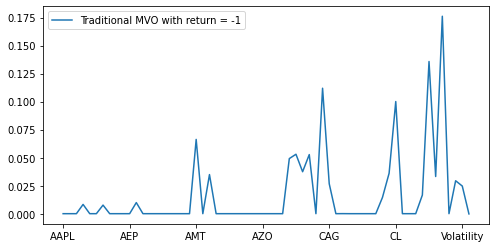

In [148]:
MVO.get_results(fig_size=(8,4))

Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca

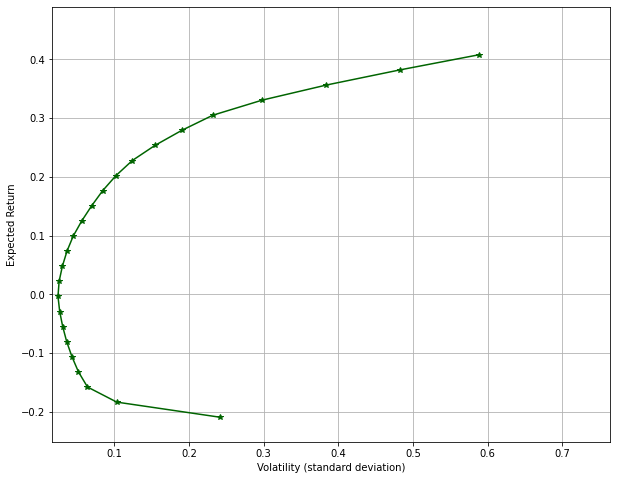

In [149]:
MVO.model.setParam('OutputFlag', 0)
MVO_frontier = MVO.get_frontier();

### Mean Variance and SVM Joint Formulation

In [150]:
SVM_MVO = SVMMVO(tics, mean, cov, ret_constr, soft_margin, Y_, svm_choice = (True, False))
SVM_MVO.setModel()
SVM_MVO.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Optimize a model with 242 rows, 123 columns and 840 nonzeros
Model fingerprint: 0x2f4e1dbf
Model has 1832 quadratic objective terms
Variable types: 63 continuous, 60 integer (60 binary)
Coefficient statistics:
  Matrix range     [2e-03, 1e+03]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e-05, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 1e+02]
Presolve removed 51 rows and 25 columns
Presolve time: 0.01s
Presolved: 191 rows, 98 columns, 630 nonzeros
Presolved model has 1832 quadratic objective terms
Variable types: 63 continuous, 35 integer (35 binary)

Root relaxation: objective 6.306776e-04, 118 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Inc

,SVM MVO with no Slacks with return = -1,Traditional MVO with return = -1
AAPL,0.001000,3.830745e-08
ABC,0.001000,1.734502e-08
ABMD,0.001000,6.942599e-08
ABT,0.009607,8.266808e-03
ADBE,0.001000,1.687418e-08
...,...,...
COP,0.173940,1.762174e-01
COST,0.001000,5.102762e-08
CPB,0.032404,2.938698e-02
Volatility,0.025461,2.465759e-02


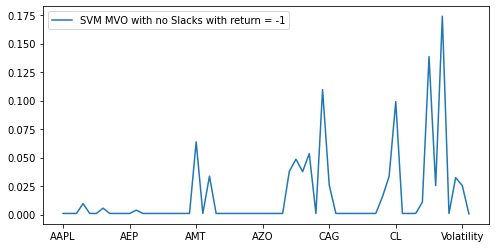

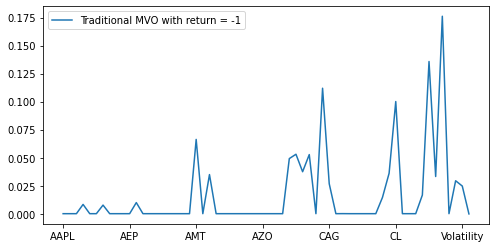

In [151]:
pd.concat([SVM_MVO.get_results(fig_size=(8,4)), MVO.get_results(fig_size=(8,4))], axis = 1)

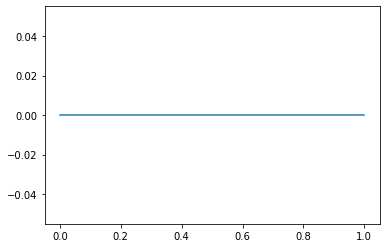

In [152]:
plt.plot(SVM_MVO.w.x);

In [153]:
SVM_MVO.get_frontier()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Optimize a model with 242 rows, 123 columns and 840 nonzeros
Model fingerprint: 0xee7ce645
Model has 1832 quadratic objective terms
Variable types: 63 continuous, 60 integer (60 binary)
Coefficient statistics:
  Matrix range     [2e-03, 1e+03]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e-05, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 1e+02]

MIP start from previous solve did not produce a new incumbent solution

Presolve removed 77 rows and 27 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.04 seconds
Thread count was 1 (of 2 available processors)

Solution count 0

Model is infeasible or unbounded
Best objective -, best bound -, gap -


### There must be a model that is guaranteed to be feasible. Slack variables for the big M constraints will be introduced and penalized

$$
\begin{align} 
\min_{x, z, w, b} \quad & x^{\intercal}\Sigma x + \frac{1}{2}||{w}||^2 + \sum_{i=1}^N g(\xi_i)&\\ 
\textrm{s.t.} \quad & \mu^\intercal x  \geq \bar{R} \\
\quad & z_i \leq M x_i &\forall i = 1,2,...,N  \\
\quad & x_i \leq z_i \quad &\forall i = 1,2,...,N \\
              \quad & y_i^{\intercal} w + b \leq M z_i - \epsilon + \xi_i \quad & \forall i = 1,2,...,N \\
              \quad & -M(1-z_i) + \epsilon - \xi_i \leq  y_i^{\intercal} w + b \quad &\forall i = 1,2,...,N \\
              \quad & x \in \mathcal{C} \quad z \in \{0,1\}^N  \quad \xi \geq 0& \\
\end{align} 
$$

This model is always feasible. A common setting for g is $C \xi/N$ where $C$ is a hyperparameter. 

In [154]:
SVM_MVO_Slck = SVMMVO(tics, mean, cov, ret_constr, soft_margin, Y_, svm_choice = (True, True))
SVM_MVO_Slck.setModel()
SVM_MVO_Slck.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Optimize a model with 242 rows, 183 columns and 960 nonzeros
Model fingerprint: 0x57e9040e
Model has 1832 quadratic objective terms
Variable types: 123 continuous, 60 integer (60 binary)
Coefficient statistics:
  Matrix range     [2e-03, 1e+03]
  Objective range  [7e-01, 7e-01]
  QObjective range [3e-05, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 1e+02]
Found heuristic solution: objective 8.000000e+10
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 241 rows, 183 columns, 900 nonzeros
Presolved model has 1832 quadratic objective terms
Variable types: 123 continuous, 60 integer (60 binary)

Root relaxation: objective 6.079909e-04, 147 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      

Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
return -0.2092948238318284
w [6.16142827e-09 0.00000000e+00]
z [0.00000000e+00 9.99997179e-06 9.99992106e-06 0.00000000e+00
 0.00000000e+00 0.00000000e+00 9.99998194e-06 0.00000000e+00
 9.99997030e-06 9.99999430e-06 9.99998227e-06 9.99997251e-06
 0.00000000e+00 9.99995705e-06 0.00000000e+00 9.99999578e-06
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 9.99998788e-06
 0.00000000e+00 9.99999136e-06 0.00000000e+00 0.00000000e+00
 9.99998336e-06 9.99999450e-06 0.00000000e+00 0.00000000e+00
 9.99997540e-06 0.00000000e+00 0.00000000e+00 9.99964096e-06
 9.99999254e-06 0.00000000e+00 0.00000000e+00 9.99999227e-06
 9.99998302e-06 0.00000000e+00 0.00000000e+00 9.99996185e-06
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 9.99998323e-06 0.00000000e+00 0.00000000e+00
 9.99997955e-06 9.99999054e-06 0.00000000e+00 9.99998

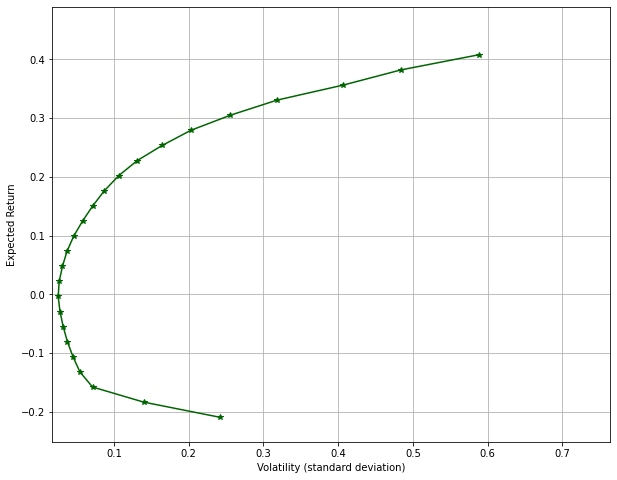

In [155]:
SVM_MVO_Slck.model.setParam('OutputFlag', 0)
SVMV_Slck_EF = SVM_MVO_Slck.get_frontier()

In [156]:
SVMV_Slck_EF - MVO_frontier

array([[9.96480676e-13, 3.64622347e-02, 7.28590622e-03, 2.50146551e-03,
        1.94306329e-03, 1.50918568e-03, 1.18328968e-03, 9.77291721e-04,
        8.22554688e-04, 7.06675481e-04, 6.99244145e-04, 6.64426903e-04,
        1.25065293e-03, 1.75542322e-03, 2.06117835e-03, 2.89458359e-03,
        4.27568654e-03, 7.23181354e-03, 1.01795647e-02, 1.24656297e-02,
        2.38389439e-02, 2.01749836e-02, 2.30259846e-02, 1.61281997e-03,
        6.67799149e-13],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00]])

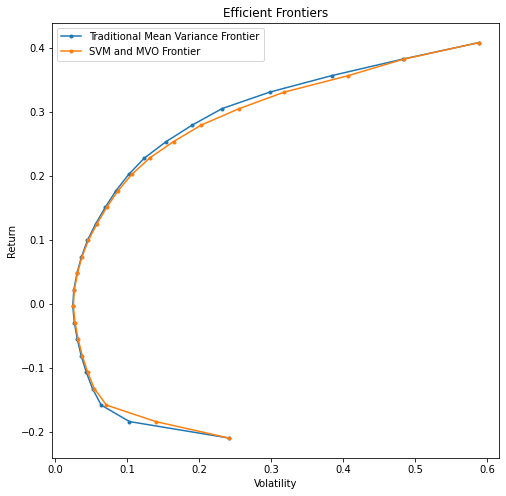

In [157]:
plt.figure(figsize = (8,8))
plt.plot(MVO_frontier[0], MVO_frontier[1], ".-", label = "Traditional Mean Variance Frontier");
plt.plot(SVMV_Slck_EF[0], SVMV_Slck_EF[1], ".-", label = "SVM and MVO Frontier");
plt.legend();
plt.ylabel('Return')
plt.xlabel('Volatility')
plt.title("Efficient Frontiers");

In [45]:
SVM_MVO_Slck.xi.X

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     